# Multi-Armed Bandits

In [12]:
from typing import Union
from functools import partial
import collections
import matplotlib.pyplot as plt
import numpy as np

In the setup below, we assume the following:

1. We start at $t=0$ and thus there is no previous action or current reward. 
2. All arms must be pulled at least **once** before executing the entire algorithm - this is known as $warm\_up$. 
3. Our focus is on system that returns a binary reward (for each arm) on the basis of a success or a failure through a probability measure - this is known as **multi-armed-bernoulli-bandits**.

Depending on the current needs, we can adapt the code - an alternative setup is considered in the `.py` files.

In [13]:
class BernoulliBandit:
    
    def __init__(self, success_probabilities, success_reward=1, fail_reward=0):
      """
      Constructor of a stationary Bernoulli bandit.
      """
      self._probs = success_probabilities
      self._number_of_arms = len(self._probs)
      self._s = success_reward
      self._f = fail_reward
      ps = np.array(success_probabilities)
      self._values = ps * success_reward + (1 - ps) * fail_reward

    def step(self, action):
      """
      The step function which takes an action and returns a reward sampled 
      according to the success probability of the selected arm.
      """
      if action < 0 or action >= self._number_of_arms:
        raise ValueError('Action {} is out of bounds for a '
                        '{}-armed bandit'.format(action, self._number_of_arms))

      success = bool(np.random.random() < self._probs[action])
      reward = success * self._s + (not success) * self._f
      return reward

    def regret(self, action):
      """
      Computes the regret for the given action.
      """
      return self._values.max() - self._values[action]

    def optimal_value(self):
      """
      Computes the regret for the given action.
      """
      return self._values.max()

In [14]:
class Random:

    def __init__(self, name, number_of_arms):
        """
        A random agent.
        This agent returns an action between 0 and 'number_of_arms', uniformly at
        random. The 'previous_action' argument of 'step' is ignored.
        """
        self._number_of_arms = number_of_arms
        self.name = name

    def step(self, bandit):
        """
        Returns a random action.
        The inputs are ignored, but this function still requires an action and a
        reward, to have the same interface as other agents who may use these inputs
        to learn.
        """
        action = np.random.randint(self._number_of_arms)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()
        return reward, regret, optimal_value

    def reset(self):
        pass

In [15]:
class EpsilonGreedy:

    def __init__(self, name: str, number_of_arms: int, epsilon=Union[float, callable]):
        """
        Initialise epsilon-greedy agent.
        - This agent returns an action between 0 and 'number_of_arms'.
        - It does so with probability `(1-epsilon)` it chooses the action with the highest estimated value, while
        with probability `epsilon`, it samples an action uniformly at random.
        """
        self.name = name
        self._number_of_arms = number_of_arms
        self._epsilon = epsilon
        self.reset()

    def step(self, bandit) -> int:
        """
        Execute Epsilon-Greedy agent's next action and update Epsilon Greedy's action-state values.
        """
        # All actions must be selected at least once before Epsilon-Greedy is applied
        if np.any(self.N_t == 0):
            # Select non-explored action
            action = np.random.choice(np.where(self.N_t == 0)[0])
            # Obtain current reward
            reward = bandit.step(action)
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[action] += (1 / self.N_t[action]) * (reward - self.Q_t[action])
        else:
            # Check if epsilon is scalar or callable
            new_epsilon = self._epsilon if np.isscalar(self._epsilon) else self._epsilon(self.t)
            # A_t(a) is the 'action' chosen at time step 't'
            action = np.random.choice(np.where(self.Q_t == np.max(self.Q_t))[0]) if np.random.uniform() < 1 - new_epsilon else np.random.randint(0, self.Q_t.shape[0])
            # Obtain current reward
            reward = bandit.step(action)
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[action] += (reward - self.Q_t[action]) / self.N_t[action]
        # Calculate regret and optimal value 
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()
        # Update time step counter
        self.t += 1
        return reward, regret, optimal_value

    def reset(self):
        """
        Reset Epsilon Greedy agent.
        """
        # Q_t(a) is the estimated value of action ‘a’ at time step ‘t’
        self.Q_t = np.zeros(self._number_of_arms)
        # N_t(a) is the number of times that action ‘a’ has been selected, prior to time ‘t’
        self.N_t = np.zeros(self._number_of_arms)
        # Set time step counter
        self.t = 0

In [16]:
class UCB:
    
    def __init__(self, name: str, number_of_arms: int, bonus_multiplier: float):
        """
        Initialise UCB agent. 
        - This agent returns an action between 0 and 'number_of_arms'.
        - This agent uses uncertainty in the action-value estimates for balancing exploration and exploitation.
        """
        self._number_of_arms = number_of_arms
        self._bonus_multiplier = bonus_multiplier
        self.name = name
        self.reset()

    def step(self, bandit) -> int:
        """
        Execute UCB agent's next action and update UCB's action-state values.
        """
        # All actions must be selected at least once before UCB is applied
        if np.any(self.N_t == 0):
            # Select non-explored action
            action = np.random.choice(np.where(self.N_t == 0)[0])
            # Obtain current reward
            reward = bandit.step(action)
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[action] += (1 / self.N_t[action]) * (reward - self.Q_t[action])
        else:
            # Calculate expected reward values
            reward_values = self.Q_t + self._bonus_multiplier * np.sqrt(np.log(self.t) / self.N_t)
            # A_t(a) is the 'action' chosen at time step 't'
            action = np.random.choice(np.where(reward_values == np.max(reward_values))[0])
            # Obtain current reward
            reward = bandit.step(action)
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)|
            self.Q_t[action] += (1 / self.N_t[action]) * (reward - self.Q_t[action])
        # Calculate regret and optimal value 
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()
        # Update time step counter
        self.t += 1
        return reward, regret, optimal_value

    def reset(self):
        """
        Reset UCB agent.
        """
        # Q_t(a) is the estimated value of action ‘a’ at time step ‘t’
        self.Q_t = np.zeros(self._number_of_arms)
        # N_t(a) is the number of times that action ‘a’ has been selected, prior to time ‘t’
        self.N_t = np.zeros(self._number_of_arms)
        # Set time step counter
        self.t = 0

In [17]:
# Run experiments repeatedly
def run_experiments(bandit_constructor, algs, repetitions, number_of_steps):
  # Store actions
  action_dict = {}
  # Store rewards
  reward_dict = {}
  # Store regret
  regret_dict = {}
  # Store optimal value
  optimal_value_dict = {}
  # Loop through algorithms
  for alg in algs:
    # For each algorithm, create dictionary storing rewards, regret and optimal values
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    # Loop through number of repetitions
    for _rep in range(repetitions):
      # Create Bernoulli Bandit simulation
      bandit = bandit_constructor()
      # Reset algorithm
      alg.reset()
      # Execute Multi-Armed Simulation
      for _step in range(number_of_steps):
        # Obtain action, reward, regret and optimal value at current time step
        reward, regret, optimal_value = alg.step(bandit)
        # Store results
        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value
  return reward_dict, regret_dict, optimal_value_dict

In [18]:
# Helper functions
def smooth(array, smoothing_horizon=100., initial_value=0.):
    """Smoothing function for plotting."""
    smoothed_array = []
    value = initial_value
    b = 1./smoothing_horizon
    m = 1.
    for x in array:
        m *= 1. - b
        lr = b/(1 - m)
        value += lr*(x - value)
        smoothed_array.append(value)
    return np.array(smoothed_array)
def calculate_lims(data, log_plot=False):
    """Calculating limits."""
    y_min = np.min(data)
    y_max = np.max(data)
    diff = y_max - y_min
    if log_plot:
        y_min = 0.9*y_min
        y_max = 1.1*y_max
    else:
        y_min = y_min - 0.05*diff
        y_max = y_max + 0.05*diff
    return y_min, y_max

In [19]:
# Plot experiments
def plot(algs, plot_data, repetitions=30):
    algs_per_row = 4
    n_algs = len(algs)
    n_rows = (n_algs - 2)//algs_per_row + 1
    fig = plt.figure(figsize=(10, 4*n_rows))
    fig.subplots_adjust(wspace=0.3, hspace=0.35)
    clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
    lss = ['--', '-', '-', '-', '-']
    for i, p in enumerate(plot_data):
      for c in range(n_rows):
        ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
        ax.grid(0)
        current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
        for alg, clr, ls in zip(current_algs, clrs, lss):
          data = p.data[alg.name]
          m = smooth(np.mean(data, axis=0))
          s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
          if p.log_plot:
            line = plt.semilogy(m, alpha=0.7, label=alg.name,
                                color=clr, ls=ls, lw=3)[0]
          else:
            line = plt.plot(m, alpha=0.7, label=alg.name,
                            color=clr, ls=ls, lw=3)[0]
            plt.fill_between(range(len(m)), m + s, m - s,
                            color=line.get_color(), alpha=0.2)
        if p.opt_values is not None:
          plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                  label='optimal')

        ax.set_facecolor('white')
        ax.tick_params(axis="both", which="both", bottom="off", top="off",
                      labelbottom="on", left="off", right="off", labelleft="on")
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set(visible=True, color='black', lw=1)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set(visible=True, color='black', lw=1)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

        data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
        
        if p.log_plot:
          start, end = calculate_lims(data, p.log_plot)
          start = np.floor(np.log10(start))
          end = np.ceil(np.log10(end))
          ticks = [_*10**__
                  for _ in [1., 2., 3., 5.]
                  for __ in [-2., -1., 0.]]
          labels = [r'${:1.2f}$'.format(_*10** __)
                    for _ in [1, 2, 3, 5]
                    for __ in [-2, -1, 0]]
          plt.yticks(ticks, labels)
        plt.ylim(calculate_lims(data, p.log_plot))
        plt.locator_params(axis='x', nbins=4)
        
        plt.title(p.title)
        if i == len(plot_data) - 1:
          plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [20]:
# Train Reinforcement Learning Algorithsms
def train_agents(agents, number_of_arms, 
                 number_of_steps, repetitions=100,
                 success_reward=1, fail_reward=0,
                 bandit_class=BernoulliBandit):
        # Note succcess probabilities of pulling an arm
        success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))
        # Create Bernoulli Bandit construct
        bandit_constructor = partial(bandit_class,
                                     success_probabilities=success_probabilities,
                                     success_reward=success_reward,
                                     fail_reward=fail_reward)
        # Run experiment
        rewards, regrets, opt_values = run_experiments(bandit_constructor, agents, repetitions, number_of_steps)
        # Plot experiments
        smoothed_rewards = {}
        for agent, rs in rewards.items():
            smoothed_rewards[agent] = np.array(rs)
        PlotData = collections.namedtuple('PlotData',
                                            ['title', 'data', 'opt_values', 'log_plot'])
        total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
        plot_data = [
            PlotData(title='Smoothed rewards', data=smoothed_rewards,
                    opt_values=opt_values, log_plot=False),
            PlotData(title='Current Regret', data=regrets, opt_values=None,
                    log_plot=True),
            PlotData(title='Total Regret', data=total_regrets, opt_values=None,
                    log_plot=False),
        ]
        plot(agents, plot_data, repetitions)

# Bernoulli Bandit - 5 arms (reward=1 on success, and reward=0 on failure)

In [21]:
%%capture experiment1
number_of_arms = 5
number_of_steps = 1000
agents = [Random(name="Random",
                 number_of_arms=number_of_arms),
          EpsilonGreedy(name=r"Greedy ($\epsilon=0$)", 
                        number_of_arms=number_of_arms, 
                        epsilon=0),
          EpsilonGreedy(name=r"Epsilon-Greedy ($\epsilon=\frac{1}{\sqrt{t}}$)", 
                        number_of_arms=number_of_arms, 
                        epsilon=lambda t: 1/np.sqrt(t)),
          EpsilonGreedy(name=r"Epsilon-Greedy ($\epsilon=\frac{1}{t}$)", 
                        number_of_arms=number_of_arms, 
                        epsilon=lambda t: 1/t),
          UCB(name=r"UCB ($c=2$)", 
              number_of_arms=number_of_arms, 
              bonus_multiplier=1/np.sqrt(2))]
train_agents(agents, number_of_arms, number_of_steps)

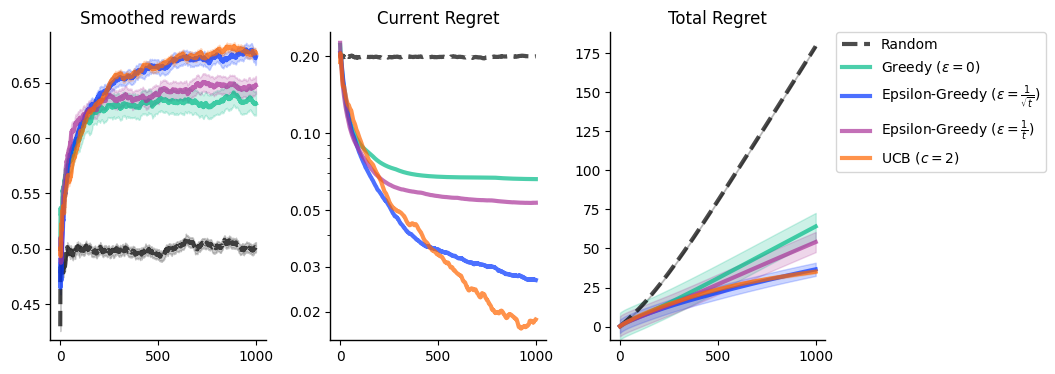

In [22]:
# Display plots
experiment1.show()

# Questions

1. What do you notice about $N_{t}\left(a\right)$ for the respective algorithms? Do any of them look similar or different?
2. What do you notice about $Q_{t}\left(a\right)$ for the respective algorithms? Do any of them look similar or different?
3. What happens if you change the $number\_of\_arms$?
4. What happens if you change the $number\_of\_steps$?
5. What happens if you change the $epsilon$ value in Epsilon-Greedy?
6. What happens if you change the $multiplier$ value in UCB?
7. What happens if you change the $num\_iter$?
8. What happens if you make sure that it does not matter if all arms are pulled at least once first?
9. What happens if you change the $reward\_dist$ i.e. no longer Bernoulli Bandit rewards?
10. What happens if the distribution of rewards became non-stationary i.e. changed after every pull?

# Final Remarks

Thank you for reading this notebook. Note that there are other implementations of recurrent neural networks (which I would advise you to take a look at to see any differences of similarities with this version).
If there are any mistakes or things that need more clarity, feel free to respond and I will be happy to reply 😊.

© *PolyNath 2023*